In [1]:
import pandas as pd 
from Bio import SeqIO
#handle fasta files
from Bio import SeqIO
#handle alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
from collections import Counter 
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns
import re
from ete3 import Tree, PhyloTree

from scipy.sparse import lil_matrix
from scipy import sparse
from scipy.sparse.linalg import spsolve

from numpy.linalg import solve, norm

from numpy.random import rand

In [2]:
path_local = "U:/users/mamorel/Projet_Convergence/condor-analysis/"

## Create DRMs Dataset

In [3]:

DRMs_file_update = path_local+"data/HIV_africa/preprocessing/RT_DRMupdate2019.txt"
DRM_list = []
with open(DRMs_file_update) as f:
    for line in f:
        DRM_list.append(line.strip())

In [4]:
drm_associated_positions = list(re.findall(r'\d+[0-9]', ",".join(DRM_list)))
variants = [i[-1] for i in DRM_list]

drms_df = pd.DataFrame([DRM_list, drm_associated_positions, variants]).T
drms_df.columns =["ancposmut", "RT_position", "mut"]
drms_df["pastml_root"] = [i[0] for i in drms_df.ancposmut]
AA = list("ARNDCQEGHILKMFPSTWYV")

drms_df = drms_df[(drms_df.mut.isin(AA)) & (drms_df.RT_position.astype(int) <= 250)]

In [5]:
tips_file = path_local+"data/HIV_africa/align.noCRF.jphmm_outgroup.aa.fa"
Align_tips = AlignIO.read(open(tips_file),"fasta")
Tips_df = pd.DataFrame([list(rec.seq) for rec in Align_tips], index = [rec.id for rec in Align_tips])
A_tips = Tips_df.describe()
consensus_tips = list("".join(A_tips.loc["top"].values))
step = int("".join(consensus_tips).find("PISPIE"))-1

In [6]:
phenotype = path_local+"data/HIV_africa/id_phenotype.txt"
pheno = []
with open(phenotype) as f:
    for line in f:
        pheno.append(line.strip())

In [7]:
real_nb_seq = []
for i,j in zip(drms_df.RT_position, drms_df.mut):
    if int(i)+step <= 250:
        real_nb_seq.append(Counter(Tips_df[int(i)+step])[j])
    else: 
        real_nb_seq.append(0)

drms_df["real_nb_seq"] = real_nb_seq

len(drms_df[(drms_df.real_nb_seq >= 10)])

29

In [8]:
drms_df = drms_df[drms_df.real_nb_seq >= 10]

## Detections

In [9]:
all_substitutions = pd.read_csv(
        path_local
        + "results/HIV_africa/condor/tested_results.tsv",
        sep="\t",
    )

#### MODEL MISPECIFICATION

In [38]:
all_substitutions_JTT = pd.read_csv(
        path_local
        + "results/HIV_africa/condor/model_misspecification_JTT/tested_results.tsv",
        sep="\t",
    )

## ADD FADE

In [10]:
FADE = pd.read_csv(path_local+"results/HIV_africa/FADE/datamonkey_fade_conjunction_HIVb.csv", sep=",")

FADE.columns = ["mut","position","rate", "bias", "proba", "BF", "composition", "substitutions"]
FADE["posmut"] = FADE["position"].astype(str)+FADE["mut"]

all_substitutions["posmut"] = [
"".join([str(i), j]) for i, j in zip(all_substitutions.position, all_substitutions.mut)
]

All_bayes_Fade = pd.merge(all_substitutions, FADE, on=["posmut", "position", "mut"], how = "left")


#### MODEL MISPECIFICATION

In [50]:
FADE_JTT = pd.read_csv(path_local+"results/HIV_africa/FADE/datamonkey_fade_conjunction_JTT.csv", sep=",")

FADE_JTT.columns = ["mut","position","rate", "bias", "proba", "BF", "composition", "substitutions"]
FADE_JTT["posmut"] = FADE_JTT["position"].astype(str)+FADE_JTT["mut"]

all_substitutions_JTT["posmut"] = [
"".join([str(i), j]) for i, j in zip(all_substitutions_JTT.position, all_substitutions_JTT.mut)
]

All_bayes_Fade_JTT = pd.merge(all_substitutions_JTT, FADE_JTT, on=["posmut", "position", "mut"], how = "left")


## ADD PCOC

In [11]:

pcoc_results_all = pd.read_csv(path_local+"results/HIV_africa/PCOC/align.noCRF.jphmm.aa.results.tsv", sep="\t")
subset_pcoc_results = pd.DataFrame(pcoc_results_all[pcoc_results_all.Sites.isin(all_substitutions.position)])
subset_pcoc_results.rename(columns={"Sites": "position"}, inplace = True)
All_bayes_fade_pcoc = pd.merge(All_bayes_Fade, subset_pcoc_results , on="position")

#### Model Misspecification

In [52]:

pcoc_results_all_JTT = pd.read_csv(path_local+"results/HIV_africa/PCOC/align.noCRF.jphmm.aa.results.tsv", sep="\t")
subset_pcoc_results_JTT = pd.DataFrame(pcoc_results_all[pcoc_results_all.Sites.isin(all_substitutions.position)])
subset_pcoc_results_JTT.rename(columns={"Sites": "position"}, inplace = True)
All_bayes_fade_pcoc_JTT = pd.merge(All_bayes_Fade_JTT, subset_pcoc_results_JTT , on="position")

In [53]:
print(len(All_bayes_fade_pcoc),len(All_bayes_fade_pcoc_JTT))

240 240


## Analysis

In [54]:
set(All_bayes_fade_pcoc[(All_bayes_fade_pcoc.PC > 0.8) & (All_bayes_fade_pcoc.correlation == "positive") ].position).intersection(drms_df.RT_position.values.astype(int))

{101, 138, 188, 210, 215, 219, 221, 227}

In [55]:
All_bayes_fade_pcoc.columns

Index(['pastml_root', 'consensus_roto', 'position', 'mut', 'max_anc',
       'ref_EEM', 'nbseq', 'evol_rate', 'genetic_distance',
       'substitution_rate', 'findability', 'type_substitution', 'details',
       'loss', 'loss_details', 'max_simu', 'variance', 'mean', 'pvalue_raw',
       'adjust_pvalue', 'adjust_pvalue_fdr', 'detected_EEM', 'posmut',
       'log-dep', 'log-indep', 'BF_x', 'correlation', 'rate', 'bias', 'proba',
       'BF_y', 'composition', 'substitutions', 'Indel_prop',
       'Indel_prop(ConvLeaves)', 'PCOC', 'PC', 'OC'],
      dtype='object')

In [12]:
methods_detect = []
#criterion bf : BF >=10 & c == "positive"
#criterion condor : p <= 0.1
#criterion pcoc : PC > 0.9
#criterion condorBT : p <= 0.1 & BF >=10 & c == "positive"

for p,bf,c,oc,pc, fade in  zip(All_bayes_fade_pcoc["adjust_pvalue"], All_bayes_fade_pcoc["BF_x"] , All_bayes_fade_pcoc["correlation"], All_bayes_fade_pcoc["OC"], All_bayes_fade_pcoc["PC"], All_bayes_fade_pcoc["BF_y"]) : 
    if (p <= 0.1) and (bf >= 20) and (c == "positive"):
        methods_detect.append("condorBT")
    elif (c == "positive") and (pc > 0.8):
        methods_detect.append("Pcoc_pos")
    elif (c == "positive") and (oc > 0.8):
        methods_detect.append("Pcoc_pos")
    elif (pc > 0.8):
        methods_detect.append("pcoc")
    elif (oc > 0.8):
        methods_detect.append("pcoc")
    elif fade > 0:
        methods_detect.append("fade")
    elif (bf >= 20) and (c == "positive"):
        methods_detect.append("BayesTraits")
    elif p <= 0.1:
        methods_detect.append("condor")
    else:
        methods_detect.append("none")

All_bayes_fade_pcoc["method"] = methods_detect

In [45]:
methods_detect = []
#criterion bf : BF >=10 & c == "positive"
#criterion condor : p <= 0.1
#criterion pcoc : PC > 0.9
#criterion condorBT : p <= 0.1 & BF >=10 & c == "positive"

for p,bf,c,oc,pc, fade in  zip(All_bayes_fade_pcoc_JTT["adjust_pvalue"], All_bayes_fade_pcoc_JTT["BF_x"] , All_bayes_fade_pcoc_JTT["correlation"], All_bayes_fade_pcoc_JTT["OC"], All_bayes_fade_pcoc_JTT["PC"], All_bayes_fade_pcoc_JTT["BF_y"]) : 
    if (p <= 0.1) and (bf >= 20) and (c == "positive"):
        methods_detect.append("condorBT")
    elif (c == "positive") and (pc > 0.8):
        methods_detect.append("Pcoc_pos")
    elif (c == "positive") and (oc > 0.8):
        methods_detect.append("Pcoc_pos")
    elif (pc > 0.8):
        methods_detect.append("pcoc")
    elif (oc > 0.8):
        methods_detect.append("pcoc")
    elif fade > 0:
        methods_detect.append("fade")
    elif (bf >= 20) and (c == "positive"):
        methods_detect.append("BayesTraits")
    elif p <= 0.1:
        methods_detect.append("condor")
    else:
        methods_detect.append("none")

All_bayes_fade_pcoc_JTT["method"] = methods_detect

In [13]:
risk = 0.1
classification = []
for det, anc,pos,mut in zip(All_bayes_fade_pcoc.adjust_pvalue, All_bayes_fade_pcoc.pastml_root, All_bayes_fade_pcoc.position, All_bayes_fade_pcoc.mut ):
    if det <= risk:
        if "".join([anc,str(pos),mut]) in drms_df["ancposmut"].values:
            classification.append("Detected DRM")
        else: 
            classification.append("Convergent candidate")
    else:
        if "".join([anc,str(pos),mut]) in drms_df["ancposmut"].values:
            classification.append("Not detected DRM")
        else: 
            classification.append("Random mutation")
All_bayes_fade_pcoc["classification"] = classification

In [59]:
risk = 0.1
classification = []
for det, anc,pos,mut in zip(All_bayes_fade_pcoc_JTT.adjust_pvalue, All_bayes_fade_pcoc_JTT.pastml_root, All_bayes_fade_pcoc_JTT.position, All_bayes_fade_pcoc_JTT.mut ):
    if det <= risk:
        if "".join([anc,str(pos),mut]) in drms_df["ancposmut"].values:
            classification.append("Detected DRM")
        else: 
            classification.append("Convergent candidate")
    else:
        if "".join([anc,str(pos),mut]) in drms_df["ancposmut"].values:
            classification.append("Not detected DRM")
        else: 
            classification.append("Random mutation")
All_bayes_fade_pcoc_JTT["classification"] = classification

In [60]:

TP = 0
FP = 0   

def table_2_condor(df, method):
    if method == "pc":
    #pc
        dataset = df[(df.PC >= 0.8) & (df.correlation == "positive") ]  
    elif method == "FADE":
    #FADE
        dataset = df[(df.BF_y >= 100)] 
    elif method == "FADE_inf":
        dataset = df[(df.BF_y > 1e16)] 
    #emergence
    elif method == "emergence":
        dataset = df[(df.adjust_pvalue <= 0.1) ]  
    elif method == "correlation":
    #correlation
        dataset = df[(df.BF_x >= 20) & (df.correlation == "positive")]
    #condor
    else: 
        dataset = df[(df.BF_x >= 20) & (df.correlation == "positive") & (df.adjust_pvalue <= 0.1)]  
    
    results = dict(Counter(dataset.classification))
    #TP = results["Detected DRM"]
    try : 
        TP = results["Detected DRM"]+ results["Not detected DRM"]
    except KeyError:
        TP = results["Detected DRM"]
    ALL = len(df)
    P = len(df[df.classification.isin(["Detected DRM", "Not detected DRM"])])
    N = len(df[~df.classification.isin(["Detected DRM", "Not detected DRM"])])
    PP = len(dataset)
    FN = P - TP
    FP = PP-TP
    TN = ALL-PP-FN
    Recall = TP/P
    Precision = TP/PP
    F1 = 2*(Precision*Recall)/(Precision+Recall)
    F1bis = TP/(TP+((1/2)*(FP+FN)))
    TPR = Recall
    TNR = TN/N
    bal_acc = (TPR + TNR)/2 
    print([np.round(i,2) for i in [TP, FP, FN, TN, Recall, Precision,  F1]])


for method in ["pc", "FADE", "FADE_inf", "emergence", "correlation", "condor"]:
    for df in [All_bayes_fade_pcoc, All_bayes_fade_pcoc_JTT]:
        print(method)
        table_2_condor(df, method)

pc
[10, 10, 19, 201, 0.34, 0.5, 0.41]
pc
[10, 10, 19, 201, 0.34, 0.5, 0.41]
FADE
[22, 66, 7, 145, 0.76, 0.25, 0.38]
FADE
[24, 69, 5, 142, 0.83, 0.26, 0.39]
FADE_inf
[13, 6, 16, 205, 0.45, 0.68, 0.54]
FADE_inf
[14, 8, 15, 203, 0.48, 0.64, 0.55]
emergence
[20, 67, 9, 144, 0.69, 0.23, 0.34]
emergence
[21, 78, 8, 133, 0.72, 0.21, 0.33]
correlation
[16, 3, 13, 208, 0.55, 0.84, 0.67]
correlation
[16, 2, 13, 209, 0.55, 0.89, 0.68]
condor
[15, 2, 14, 209, 0.52, 0.88, 0.65]
condor
[16, 1, 13, 210, 0.55, 0.94, 0.7]


In [14]:
#pal = sns.color_palette("colorblind")
pal = sns.color_palette("Greys", 8)
print(pal.as_hex())

sns.color_palette("Greys", 8)


['#f2f2f2', '#dfdfdf', '#c6c6c6', '#a8a8a8', '#868686', '#686868', '#474747', '#212121']


[(0.9483275663206459, 0.9483275663206459, 0.9483275663206459),
 (0.8729104190695887, 0.8729104190695887, 0.8729104190695887),
 (0.7777777777777778, 0.7777777777777778, 0.7777777777777778),
 (0.6578085351787775, 0.6578085351787775, 0.6578085351787775),
 (0.5257977700884275, 0.5257977700884275, 0.5257977700884275),
 (0.40784313725490196, 0.40784313725490196, 0.40784313725490196),
 (0.27866205305651676, 0.27866205305651676, 0.27866205305651676),
 (0.12745866974240677, 0.12745866974240677, 0.12745866974240677)]

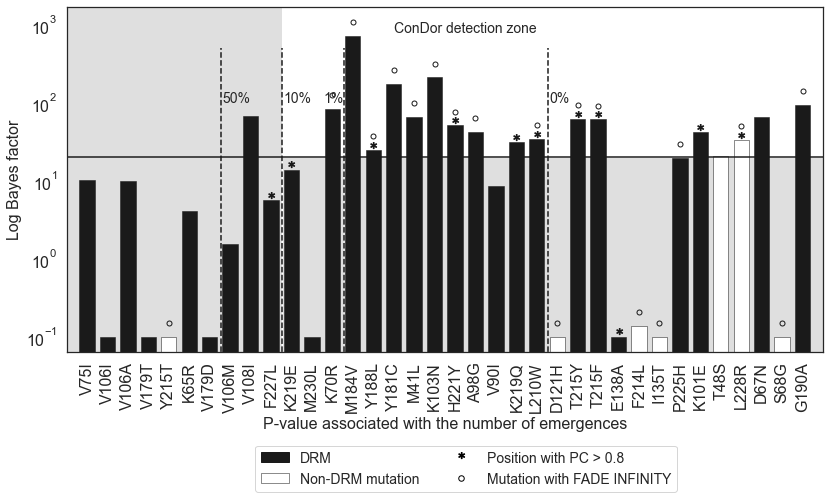

In [16]:


#dataset = pd.DataFrame(All_bayes_pcoc[(All_bayes_pcoc.classification.isin(["Detected DRM", "Not detected DRM"])) | (All_bayes_pcoc.method.isin(["condorBT"])) | (All_bayes_pcoc.PC > 0.9) & (All_bayes_pcoc.correlation == "positive")])
dataset = pd.DataFrame(All_bayes_fade_pcoc[(All_bayes_fade_pcoc.classification.isin(["Detected DRM", "Not detected DRM"])) | (All_bayes_fade_pcoc.method.isin(["condorBT"])) | (All_bayes_fade_pcoc.BF_y == np.inf)])
#take only DRM or convergent detected with BT

dataset["RT_ancposmut"] = ["".join([h,str(i),j]) for h,i,j in zip(dataset.pastml_root, dataset.position, dataset.mut)]
dataset["BF_graph"] = [i if (i > 0) and (j == "positive") else 0.1 for i,j in zip(dataset.BF_x, dataset.correlation)]

sorted_dataset = dataset.sort_values("pvalue_raw" , axis=0, ascending=False)

sns.set(style = "white")
sns.set_context("notebook", rc={"lines.linewidth": 1.5})

f,ax= plt.subplots(1,1, figsize=(11.69, 7.27))
font = 16
width = 0.75
x = np.arange(len(sorted_dataset))


############figure#####################
##color 
col_list=[]
for i,j,k in zip(sorted_dataset.classification, sorted_dataset.BF_x, sorted_dataset.method):
    if (i == "Detected DRM") and (j >= 20):
        col_list.append("k") #black
    elif (i == "Detected DRM") and (j < 20):
        col_list.append('k') 
    elif i == "Not detected DRM":
        col_list.append('k') 
    elif k == "Pcoc_pos":
        col_list.append("w") 
    else:
        col_list.append("w")

##pcoc
pcoc_filtered = All_bayes_fade_pcoc[(All_bayes_fade_pcoc.PC > 0.8) & (All_bayes_fade_pcoc.correlation == "positive")]

pcoc = []
for pc,corr in zip(sorted_dataset.PC, sorted_dataset.correlation) :
    if (pc > 0.8) and (corr == "positive") :
        pcoc.append("$*$")
    else:
        pcoc.append("")

fade = []
for f in sorted_dataset.BF_y :
    if f == np.inf :
        fade.append(".")
    else:
        fade.append("")


# positive_sel = []
# for pos in sorted_dataset.position :
#     if pos in meme.Codon.values:
#         positive_sel.append(".")
#     else:
#         positive_sel.append("")

rects1 = ax.bar(x, sorted_dataset.BF_graph.values , width, label='Log Bayes Factor', color =col_list,  linewidth = 0.5)


##lim pvalues
lim0 = len(sorted_dataset[sorted_dataset.adjust_pvalue == 0])
lim1 = len(sorted_dataset[sorted_dataset.adjust_pvalue >= 0.01])
lim10 = len(sorted_dataset[sorted_dataset.adjust_pvalue >= 0.1])
#lim5 = len(sorted_dataset[sorted_dataset.adjust_pvalue >= 0.05])
#lim25 = len(sorted_dataset[sorted_dataset.adjust_pvalue >= 0.25])
lim50 = len(sorted_dataset[sorted_dataset.adjust_pvalue >= 0.5])


ax.axhline(20 , color = 'k')

ax.vlines(ymin = 0, ymax = 500, x = lim0-width*0.6 , colors = 'k', linestyles = '--')
ax.vlines(ymin = 0, ymax = 500, x = lim1-width*0.6 , colors = 'k', linestyles = '--')
ax.vlines(ymin =0, ymax =500, x= lim10-width*0.6 , colors = 'k', linestyles = '--')
#ax.axvline(lim5-width*0.6 , color = 'k', linestyle = '--')
ax.vlines(ymin =0, ymax =500, x=lim50-width*0.6 , colors = 'k', linestyles = '--')

ax.text(s = "0%", x = lim0- width/2 , y = 100 , fontsize=14)
ax.text(s = "1%", x = lim1- 1.9*width , y = 100 , fontsize=14)
#ax.text(s = "5%", x = lim5-width , y = 1 , fontsize=font)
ax.text(s = "10%", x = lim10-width/2, y = 100 , fontsize=14)
ax.text(s = "50%", x = lim50-width/2, y = 100 , fontsize=14)


for i, patch in enumerate(ax.patches):
    if col_list[i] == "k":
        patch.set_edgecolor('k')
    else:
        patch.set_edgecolor('k')

pop_a = mpatches.Patch(color='k', label='DRM')
pop_c = mpatches.Patch(color="w", label='Non-DRM mutation', linewidth = 0.5)
pop_c.set_edgecolor("k")
round = mlines.Line2D([], [], marker='.', linestyle='None',
                       markersize=11, label='Mutation with FADE INFINITY', color='black',
                       fillstyle= 'none')
stars = mlines.Line2D([], [], marker='$*$', linestyle='None',
                          markersize=10, label='Position with PC > 0.8', color='black',
                          fillstyle= 'full')

ax.legend(handles=[pop_a, pop_c, stars, round], loc= "upper left", fontsize = 14, bbox_to_anchor=(0.24, -0.25), ncol = 2 )

ax.set_xticks(x) 
ax.margins(x=0.02) 


ax.set_ylabel("Log Bayes factor", fontsize = font)
ax.set_xlabel("P-value associated with the number of emergences", fontsize = font)

plt.yscale('log')
plt.axhspan(0, 20, facecolor=pal[1], alpha=1, zorder=-100)
plt.axvspan(-1.5, lim10-width*0.6, facecolor=pal[1], alpha=1, zorder=-100)
ax.text(s = "ConDor detection zone", x = 15, y = 800 , fontsize=14)


#plt.ylim(0.095, 1000)
plt.xlim(-1, max(x+1))


plt.yscale('log')
#plt.ylim(0, 1000)


for a, b, c in zip(x, sorted_dataset.BF_graph.values, pcoc):
    ax.plot(a, b+b*0.1, marker = c, markersize = 10, color = "k")

for a, b, c in zip(x, sorted_dataset.BF_graph.values, fade):
    ax.plot(a, b+b*0.5, marker = c, markersize = 10, color = "k", fillstyle = "none")

label_xticks = ["".join([i,str(j), k]) for i,j,k in zip(sorted_dataset.max_anc, sorted_dataset.position, sorted_dataset.mut)]


_= plt.setp( ax, xticklabels = label_xticks)
#_= plt.setp( ax, yticklabels = [0, 0,0,1, 10, 100, 1000])
_= plt.setp( ax.xaxis.get_majorticklabels(), rotation=90, fontsize = font)
_= plt.setp( ax.yaxis.get_majorticklabels(), fontsize = font)

plt.tight_layout()
